# Guided LDA using gensim

The gensim package for python is a well-known library of text processing routines. One of the language model frameworks that are included in the package is a Latent Dirichlet Allocation (LDA) topic modeling framework. LDA can be used as an unsupervised learning method in which topics are identified based on word co-occurrence probabilities; however with the implementation of LDA included in the gensim package we can also seed terms with topic probabilities. This turns a fully-unsupervized training method into a semi-supervized training method. Semi-supervised because we are not tagging all terms or documents with topic probabilities, just a few, but it turns out that's enough to push the model in a certain direction.

In this writeup I will show how to build an LDA model in gensim with seed words, and plot the resulting topic probability distribution that has been assigned to words. I will then train further models with seed probabilities and explore how this leads the model to different topic probability distributions.

## Importing libraries

We will of course need `gensim`, and we will be working with matrix manipulation so we will need `numpy`. `nltk` provides support functions for language processing and we will be visualizing results with `matplotlib`.

In [1]:
import gensim
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\jumaa\Anaconda3\envs\py36\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


There are a couple of additional subpackages that `nltk` requires to use the POS tagging feature and the WordNet model. We have to make sure those are downloaded.

In [2]:
# nltk.download('pos_tag')
# nltk.download('wordnet')

Let's set up a simple corpus of text strings to work with. The first two seem to relate to food, the next two to animals, and the last one a bit of both.

In [3]:
txt = [
    'I like to eat broccoli and bananas.',
    'I munched a banana and spinach smoothie for breakfast.',
    'Chinchillas and kittens are cute.',
    'My sister adopted a kitten yesterday.',
    'Look at this cute hamster munching on a piece of broccoli.'
]
len(txt)

5

The first step in most language processing analytics is preprocessing the text strings. We will be running the following on the text:  
* `gensim.simple_preprocess` - does a bunch of pre-processing steps such as tokenizing, removing punctuation and converting to lower case  
* lemmatization - turning a word into its base form, e.g. 'shaving' -> 'shave' (note this is not the same thing as stemming, which would turn 'shaving' to 'shav')

In order to perform the lemmatization, we use the `WordNet` language model provided through the `nltk` package. The `WordNetLemmatizer.lemmatize()` function takes a part-of-speech tag to tell it whether we're passing a noun, verb, adjective or adverb. This makes a difference for example 'shaving' could either be used as a verb, however it could also be used as a noun, as in "wood shaving". If we were to pass 'shaving' and indicate that it's a noun the lemmatization function would need to leave it alone since it's already in its base form. As a verb, however that would need to translate to 'shave'.  
To identify what part-of-speech any particular word is, is not easy, but `nltk` again comes to the rescue providing access to a part-of-speech tagger which returns a suitable tag for each word in a given text.

The twist is that the `nltk.pos_tag` function returns the Penn Treebank tag for the word but we just want whether the word is a noun, verb, adjective or adverb. We need a short simplification routine to translate from the Penn tag to a simpler tag.

In [4]:
# simplify Penn tags to n (NOUN), v (VERB), a (ADJECTIVE) or r (ADVERB)
def simplify(penn_tag):
    pre = penn_tag[0]
    if (pre == 'J'):
        return 'a'
    elif (pre == 'R'):
        return 'r'
    elif (pre == 'V'):
        return 'v'
    else:
        return 'n'

Now we're ready to perform some simple preprocessing on the text.

In [5]:
def preprocess(text):
    stop_words = stopwords.words('english')
    toks = gensim.utils.simple_preprocess(str(text), deacc=True)
    wn = WordNetLemmatizer()
    return [wn.lemmatize(tok, simplify(pos)) for tok, pos in nltk.pos_tag(toks) if tok not in stop_words]

In [6]:
corp = [preprocess(line) for line in txt]
corp

[['like', 'eat', 'broccoli', 'banana'],
 ['munch', 'banana', 'spinach', 'smoothie', 'breakfast'],
 ['chinchilla', 'kitten', 'cute'],
 ['sister', 'adopt', 'kitten', 'yesterday'],
 ['look', 'cute', 'hamster', 'munch', 'piece', 'broccoli']]

As you can see words have been translated to their base form and converted to lower case. Another step that we performed is omitting 'stop words' like 'this', 'on', 'are', which don't contribute much to the topic probability.

In [7]:
dictionary = gensim.corpora.Dictionary(corp)
len(dictionary)

17

We have a vocabulary of 17 words after removing stop words.

The LDA algorithm implementation in `gensim` reads the strings in a 'bag of words' format. This structure lists each distinct word in the sentence once, along with the number of times it occurs in the sentence. The gensim dictionary conveniently provides the `doc2bow` function that converts a line into its respective 'bow' format.

In [8]:
bow = [dictionary.doc2bow(line) for line in corp]
bow

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1), (9, 1), (10, 1)],
 [(10, 1), (11, 1), (12, 1), (13, 1)],
 [(1, 1), (5, 1), (9, 1), (14, 1), (15, 1), (16, 1)]]

The model parameter that tracks how words are allocated to terms is called `eta` in the gensim implementation. When not provided, or provided as the keyword `'auto'`, gensim presupposes an even distribution across terms and topics. The question we need to ask is, if we provide a non-uniform matrix as the eta parameter, does that affect the topic distribution assigned to terms and documents?

To find out, we'll first train a topic model on the corpus of sentences we set up, using the `'auto'` keyword. We will then train a model using a prior distribution skewed in the same direction as the auto-generated model, just for fun, and then train another model using a prior distribution to try to push the model in the opposite direction.

We'll set up a function that displays the probability distribution calculated by the algorithm so that we can see how the topics have been allocated across terms.

In [9]:
def viz_model(model, modeldict):
    ntopics = model.num_topics
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) for t in range(ntopics) for w,p in model.get_topic_terms(t, topn=1)]
    terms = [modeldict[w] for w in modeldict.keys()]
    fig,ax=plt.subplots()
    ax.imshow(model.get_topics())  # plot the numpy matrix
    ax.set_xticks(modeldict.keys())  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    plt.show()

We will run the following function for each test. Train a model with our prior distribution (or `'auto'`), plot the model, print out the topic distribution and show the topic allocation for our corpus.

In [10]:
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    # set the random seed for repeatability
    np.random.seed(42)
    # generate our model
    bow = [dictionary.doc2bow(line) for line in corp]
    model = gensim.models.ldamodel.LdaModel(
        corpus=bow, id2word=dictionary, num_topics=ntopics,
        random_state=42, chunksize=100, eta=eta,
        eval_every=-1, update_every=1,
        passes=150, alpha='auto', per_word_topics=True)
    # visuzlize the model term topics
    viz_model(model, dictionary)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=3)]))
    if print_dist:
        # display the topic probabilities for each document
        for line,bag in zip(txt,bow):
            doc_topics = ['({}, {:.1%})'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
            print('{} {}'.format(line, doc_topics))
    return model

Before we try a custom prior distribution, let's see how the model does with the default setting, i.e. `'auto'`.

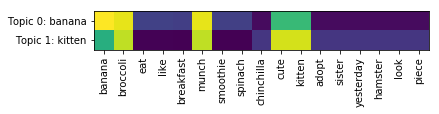

Perplexity: -2.98
Topic 0: ['banana', 'broccoli', 'munch']
Topic 1: ['kitten', 'cute', 'broccoli']
I like to eat broccoli and bananas. ['(0, 99.1%)']
I munched a banana and spinach smoothie for breakfast. ['(0, 99.2%)']
Chinchillas and kittens are cute. ['(1, 99.1%)']
My sister adopted a kitten yesterday. ['(1, 99.4%)']
Look at this cute hamster munching on a piece of broccoli. ['(1, 99.6%)']


In [11]:
test_eta('auto',dictionary,ntopics=2)

Not bad. The distribution allocated with an even start correctly identifies the first two and the next two as separate topics, but fails to identify that the last sentence contains elements of both topics.

To define a prior distribution, we need to create a numpy matrix with the same number of rows and columns as topics and terms, respectively. We then populate that matrix with our prior distribution. To do this we pre-populate all the matrix elements with 1, then with a really high number for the elements that correspond to our 'guided' term-topic distribution.

In [12]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

Let's start with a list that uses the same topic words.

C:\Users\jumaa\Anaconda3\envs\py36\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


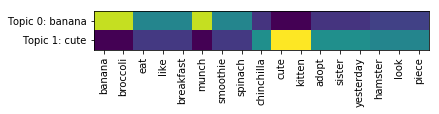

Perplexity: -1.30
Topic 0: ['broccoli', 'banana', 'munch']
Topic 1: ['kitten', 'cute', 'sister']
I like to eat broccoli and bananas. ['(0, 96.3%)', '(1, 3.7%)']
I munched a banana and spinach smoothie for breakfast. ['(0, 97.0%)', '(1, 3.0%)']
Chinchillas and kittens are cute. ['(0, 4.8%)', '(1, 95.2%)']
My sister adopted a kitten yesterday. ['(0, 3.7%)', '(1, 96.3%)']
Look at this cute hamster munching on a piece of broccoli. ['(0, 40.4%)', '(1, 59.6%)']


In [13]:
apriori_original = {
    'banana':0, 'broccoli':0, 'munch':0,
    'cute':1, 'kitten':1  # we'll leave out broccoli from this one!
}
eta = create_eta(apriori_original, dictionary, 2)
test_eta(eta, dictionary, 2)

When we guide the distribution to allocate a few words towards the 'foody' topic and others towards the 'animaly' topic, we actually get a more pronounced distribution in the same topic allocation direction, and we even get more probability assiged to both topics for the last sentence.

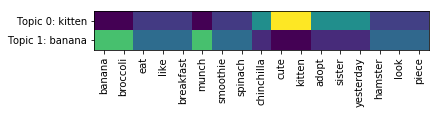

Perplexity: -1.46
Topic 0: ['kitten', 'cute', 'chinchilla']
Topic 1: ['broccoli', 'banana', 'munch']
I like to eat broccoli and bananas. ['(0, 8.3%)', '(1, 91.7%)']
I munched a banana and spinach smoothie for breakfast. ['(0, 6.9%)', '(1, 93.1%)']
Chinchillas and kittens are cute. ['(0, 86.8%)', '(1, 13.2%)']
My sister adopted a kitten yesterday. ['(0, 89.3%)', '(1, 10.7%)']
Look at this cute hamster munching on a piece of broccoli. ['(0, 22.9%)', '(1, 77.1%)']


In [14]:
apriori_opposite = {
    'cute':0, 'kitten':0,
    'banana':1, 'broccoli':1, 'munch':1
}
eta = create_eta(apriori_opposite, dictionary, 2)
test_eta(eta, dictionary, 2)

Success! We've pushed the model in the opposite direction. Terms that were previously assigned to topic 0 are now topic 1, and vice-versa. However it looks like the model struggled with this a bit! The distribution is not as clear-cut. What if we push a little harder?

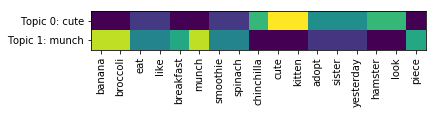

Perplexity: -1.17
Topic 0: ['kitten', 'cute', 'look']
Topic 1: ['munch', 'banana', 'broccoli']
I like to eat broccoli and bananas. ['(0, 4.1%)', '(1, 95.9%)']
I munched a banana and spinach smoothie for breakfast. ['(0, 3.3%)', '(1, 96.7%)']
Chinchillas and kittens are cute. ['(0, 94.6%)', '(1, 5.4%)']
My sister adopted a kitten yesterday. ['(0, 95.8%)', '(1, 4.2%)']
Look at this cute hamster munching on a piece of broccoli. ['(0, 50.0%)', '(1, 50.0%)']


In [15]:
apriori_harder = {
    'cute':0, 'kitten':0, 'hamster':0, 'chinchilla':0, 'look':0,
    'banana':1, 'broccoli':1, 'piece':1, 'breakfast':1, 'munch':1
}
eta = create_eta(apriori_harder, dictionary, 2)
test_eta(eta, dictionary, 2)

Clearly marking additional terms as associated with topics has provided more polarization to the model.

We have seen that by providing a prior term-topic distribution to the model we can guide the LDA towards a useful topic model.

However I have one last question. Since the LDA training algorithm is iterative in nature, does the order of the words in the dictionary have an effect on the result? Let's find out. First let's take a look at the dictionary we have right now.

In [16]:
print([dictionary[w] for w in dictionary.keys()])

['banana', 'broccoli', 'eat', 'like', 'breakfast', 'munch', 'smoothie', 'spinach', 'chinchilla', 'cute', 'kitten', 'adopt', 'sister', 'yesterday', 'hamster', 'look', 'piece']


Let's create a new one with a different word ordering.

In [17]:
dictionary2 = gensim.corpora.Dictionary(
    [['banana', 'broccoli', 'eat', 'like', 'breakfast', 'munch', 'smoothie', 'spinach', 'chinchilla',
    'cute', 'kitten', 'adopt', 'sister', 'yesterday', 'hamster', 'look', 'piece']]
)
print([dictionary2[w] for w in dictionary2.keys()])

['adopt', 'banana', 'breakfast', 'broccoli', 'chinchilla', 'cute', 'eat', 'hamster', 'kitten', 'like', 'look', 'munch', 'piece', 'sister', 'smoothie', 'spinach', 'yesterday']


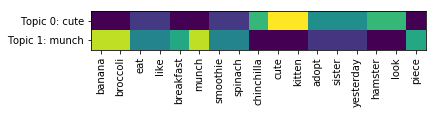

Perplexity: -1.17
Topic 0: ['kitten', 'cute', 'look']
Topic 1: ['munch', 'banana', 'broccoli']
I like to eat broccoli and bananas. ['(0, 4.1%)', '(1, 95.9%)']
I munched a banana and spinach smoothie for breakfast. ['(0, 3.3%)', '(1, 96.7%)']
Chinchillas and kittens are cute. ['(0, 94.6%)', '(1, 5.4%)']
My sister adopted a kitten yesterday. ['(0, 95.8%)', '(1, 4.2%)']
Look at this cute hamster munching on a piece of broccoli. ['(0, 50.0%)', '(1, 50.0%)']


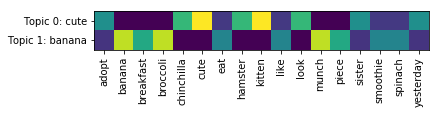

Perplexity: -1.17
Topic 0: ['cute', 'kitten', 'chinchilla']
Topic 1: ['munch', 'banana', 'broccoli']
I like to eat broccoli and bananas. ['(0, 3.9%)', '(1, 96.1%)']
I munched a banana and spinach smoothie for breakfast. ['(0, 3.2%)', '(1, 96.8%)']
Chinchillas and kittens are cute. ['(0, 94.8%)', '(1, 5.2%)']
My sister adopted a kitten yesterday. ['(0, 96.0%)', '(1, 4.0%)']
Look at this cute hamster munching on a piece of broccoli. ['(0, 50.0%)', '(1, 50.0%)']


In [18]:
eta = create_eta(apriori_harder, dictionary, 2)
test_eta(eta, dictionary, 2)

eta = create_eta(apriori_harder, dictionary2, 2)
test_eta(eta, dictionary2, 2)

While there are minor differences in the ordering of the topic terms and the document topic probabilities, the two models are almost identical.